In [1]:
from brian2 import *
from brian2tools import *
%matplotlib inline
np.set_printoptions() 
#np.set_printoptions(threshold=12)


This code uses the Brian2 neuromorphic simulator code to implement
 a version of role/filler binding and unbinding based on the 
paper :High-Dimensional Computing with Sparse Vectors" by Laiho et al 2016. 
The vector representation is a block structure comprising slots_per_vector 
where the number of slots_per_vector is the vector dimension. In each slot there are a
number of possible bit positions with one bit set per slot. 
In this implementation we implement the role/filler binding and unbinding 
operations in Brian2 by representing each slot as a neuron and the time delay
 of the neuron's spike as the bit position.  

To ensure that the Brian2 network is performing correctly the first section of the code 
computes the expected sparse bound vector.  
The neuromorphic equivalent is implemented as two Brian2 networks.  The first network (net1) implements
the role/filler binding and the second netwok (net2) implements the role/filler unbinding and the clean-up memory
operation which compares the unbound vector with all the memory vectors to find the best match.
The sparse bound vector resulting from net1 is passed to net2 to initiate the unbinding.

## Init base vars

In [2]:
show_bound_vecs_slot_detail = True

# Initialise the network parameters
slots_per_vector = 500  # This is the number of neurons used to represent a vector
bits_per_slot = 512  # This is the number of bit positions
mem_size = 1000  # The number of vectors against which the resulting unbound vector is compared
Num_bound = 20  # The number of vectors that are to be bound
input_delay = bits_per_slot  # Time delay between adding cyclically shifted vectors to construct the bound vector is set to 'bits' milliseconds.

# NB all timings use milliseconds and we can use a random seed if required.
# np.random.seed(123321)

target_neuron = 1
y_low = 0  # This is used to select the lowest index of the range of neurons that are to be displayed
y_high = slots_per_vector - 1  # This is used to select the highest index of the range of neurons that are to be displayed

delta = (Num_bound) * bits_per_slot  # This determins the time period over which the Brian2 simulation is to be run.



## Create a set of sparse VSA vectors
Generate a random matrix (P_matrix) which represents all of the sparse vectors that are to be used.
This matrix has columns equal to the number of slots_per_vector in each vector with the number of rows equal to the memory size (mem_size)


In [3]:
P_matrix = np.random.randint(0, bits_per_slot, size=(mem_size,slots_per_vector))
Role_matrix = P_matrix[::2]
Val_matrix = P_matrix[1::2]

print(P_matrix)

[[164 356 321 ...  59 334 457]
 [232 443 144 ... 347 424 110]
 [366 329  70 ... 443  35 242]
 ...
 [ 63 471 392 ... 340 502  32]
 [148 500 255 ... 233 340 215]
 [439  23 347 ... 248 322 413]]


## Demonstration of modulo addition binding

In [4]:
test_target_neuron = target_neuron  # Change this to try different columns e.g. 0, 1, 2....
print(f"Showing modulo {bits_per_slot} addition role+filler bind/unbind for target column {test_target_neuron}\n") 
for n in range(0,2*Num_bound,2):
    bind_val = (P_matrix[n][test_target_neuron]+P_matrix[n+1][test_target_neuron])%bits_per_slot
    print(f"\t{P_matrix[n][test_target_neuron]:2d}+{P_matrix[n+1][test_target_neuron]:2d}="
          f"{P_matrix[n][test_target_neuron]+P_matrix[n+1][test_target_neuron]:2d} %"
          f" {bits_per_slot} = {bind_val:2d} Bind")    

    unbind_val = (bind_val-P_matrix[n+1][test_target_neuron]) % bits_per_slot 
    print(f"\t{bind_val:2d}-{P_matrix[n+1][test_target_neuron]:2d}="
      f"{bind_val-P_matrix[n+1][test_target_neuron]:2d} %"
      f" {bits_per_slot} = {unbind_val:2d} Unbind\n")    


Showing modulo 512 addition role+filler bind/unbind for target column 1

	356+443=799 % 512 = 287 Bind
	287-443=-156 % 512 = 356 Unbind

	329+424=753 % 512 = 241 Bind
	241-424=-183 % 512 = 329 Unbind

	352+303=655 % 512 = 143 Bind
	143-303=-160 % 512 = 352 Unbind

	74+200=274 % 512 = 274 Bind
	274-200=74 % 512 = 74 Unbind

	245+271=516 % 512 =  4 Bind
	 4-271=-267 % 512 = 245 Unbind

	163+15=178 % 512 = 178 Bind
	178-15=163 % 512 = 163 Unbind

	266+132=398 % 512 = 398 Bind
	398-132=266 % 512 = 266 Unbind

	229+157=386 % 512 = 386 Bind
	386-157=229 % 512 = 229 Unbind

	332+120=452 % 512 = 452 Bind
	452-120=332 % 512 = 332 Unbind

	62+115=177 % 512 = 177 Bind
	177-115=62 % 512 = 62 Unbind

	157+404=561 % 512 = 49 Bind
	49-404=-355 % 512 = 157 Unbind

	417+250=667 % 512 = 155 Bind
	155-250=-95 % 512 = 417 Unbind

	76+304=380 % 512 = 380 Bind
	380-304=76 % 512 = 76 Unbind

	489+426=915 % 512 = 403 Bind
	403-426=-23 % 512 = 489 Unbind

	65+511=576 % 512 = 64 Bind
	64-511=-447 % 512 = 65 Unb

# Theoretical calc 
This section of the code computes the theoretical values for the sparse vector (which can then be compared with
the output of the net1 neuromorphic circuit. It then computes the expected number of bits_per_slot that will align in the clean-up memory operation (which can then be compared with the net2 neuromorphic circuit output).


## Create sparse representation of the bound vector

In [5]:
# We take pairs of vector and bind them together and in each slot and then store a random
# value between 0 and 1.0 in the slot (this will be used to select just one bit when we create 
# the sparse vector)

# Init sparse bound vector (s_bound) with zeros
s_bound = np.zeros((slots_per_vector, bits_per_slot))  # Create a slotted vector with

# Do the binding
for n in range(0, Num_bound):
    for s in range(0, slots_per_vector): # For each slot
        role_pos = Role_matrix[n][s]  # Position of the set bit in this role vector for this slot
        filler_pos = Val_matrix[n][s] # Position of the set bit in this value vector for this slot
        b = (filler_pos+role_pos) % bits_per_slot # Get new 'phase' (bit position) to set in the bound vector's slot
        s_bound[s][b] = rand()
        

In [6]:
if show_bound_vecs_slot_detail:
    np.set_printoptions(formatter={'int':lambda x: f"{x:2d}"})        
    print()
    if bits_per_slot > 24:
        # Fancy formating for slots_per_vector that are longer than 24 bits_per_slot - shows start and end of slot values.
        for kk in range(slots_per_vector):
            print(f"slot[{kk:2d}]:"
                  f"{((s_bound[kk]*100).astype(int))[:12]} ... {((s_bound[kk]*100).astype(int))[-12:]}, "
                  f"Argmax bit pos=[{np.argmax(s_bound[kk])}]")   
    else:
        for kk in range(slots_per_vector):
            print(f"slot[{kk:2d}]:"
                  f"{((s_bound[kk]*100).astype(int))}, "
                  f"Argmax bit pos=[{np.argmax(s_bound[kk])}]")

    np.set_printoptions() 


slot[ 0]:[ 0  0  0  0  0 95  0  0  0  0  0  0] ... [ 0  0  0  0  0  0  0  0  0  0 23  0], Argmax bit pos=[5]
slot[ 1]:[ 0  0  0  0 87  0  0  0  0  0  0  0] ... [ 0  0  0  0  0  0  0  0  0  0  0  0], Argmax bit pos=[403]
slot[ 2]:[ 0  0  0  0  0  0  0  0  0  0  0  0] ... [ 0  0  0  0  0  0  0  0  0  0  0  0], Argmax bit pos=[375]
slot[ 3]:[ 0  0  0 85  0  0  0  0  0  0  0  0] ... [ 0  0  0  0  0  0  0  0  0  0  0  0], Argmax bit pos=[201]
slot[ 4]:[ 0 14  0  0  0  0  0  0  0  0  0  0] ... [ 0  0  0  0  0  0  0  0  0  0  0  0], Argmax bit pos=[125]
slot[ 5]:[ 0  0  0  0  0  0  0  0  0  0  0  0] ... [ 0  0  0  0  0  0  0  0  0  0  0  0], Argmax bit pos=[189]
slot[ 6]:[ 0  0  0  0 88  0  0  0  0  0  0 83] ... [ 0  0  0  0  0  0  0  0  0  0  0  0], Argmax bit pos=[96]
slot[ 7]:[ 0  0  0  0  0  0  0  0  0  0  0 35] ... [ 0  0  0  0  0  0  0  0  0  0  0  0], Argmax bit pos=[215]
slot[ 8]:[ 0  0  0  0  0  0  0  0  0  0  0  0] ... [ 0  0  0  0  0  0  0  0  0  0  0  0], Argmax bit pos=[434]
slo

## Make s_bound sparse using the argmax function which finds the bit position with the highest random value.

In [7]:
np.set_printoptions(threshold=24)
np.set_printoptions(edgeitems=11)
print("\nResultant Sparse vector, value indicates 'SET' bit position in each slot. \n(Note, a value of '0' means bit zero is set).\n")

sparse_bound = np.array([np.argmax(s_bound[s]) for s in range(0,slots_per_vector)])
print(sparse_bound)
print()
np.set_printoptions()    


Resultant Sparse vector, value indicates 'SET' bit position in each slot. 
(Note, a value of '0' means bit zero is set).

[  5 403 375 201 125 189  96 215 434  97 136 ... 267 150 414   2 154 238
 317 486 203 158 278]



# Perform the unbinding

Unbind the vector sparse_bound vector and compare with each of the vectors in the P_matrix couting the
number of slots_per_vector that have matching bit positions. This gives the number of spikes that should line up 
in the clean up memory operation.

In [8]:
hd_threshold = 0.1
results_set = []
results = None
miss_matches = []
for nn in range(0, len(Role_matrix)):
    #for pvec in P_matrix:
    pvec = Role_matrix[nn]
    results = []
    for test_vec in Val_matrix:
        unbound_vals = np.array([(sparse_bound[ss]-pvec[ss]) % bits_per_slot for ss in range(0, slots_per_vector)])
        match = np.count_nonzero(unbound_vals == test_vec)
        results.append(match)
        
    win_indx = np.argmax(results)
    max_count = np.max(results)
    hd = max(results)/slots_per_vector
    #print(nn, end=' ')
    if hd > hd_threshold:
        print(f"Role_vec_idx[{nn}], Val_match_idx[{win_indx:2d}]:  {results}")
    else:
        # store the a failed match
        miss_matches.append((nn, win_indx, results))

    results_set.append(results)
print()

In [9]:
print("\nShowing failed matches:")
for fm in miss_matches:
    print(f"Role_vec_idx[{fm[0]}], Val_match_idx[{fm[1]:2d}]:  {fm[2]}")


Showing failed matches:
Role_vec_idx[0], Val_match_idx[ 0]:  [21, 2, 2, 0, 1, 2, 1, 1, 2, 0, 3, 2, 1, 1, 0, 1, 0, 3, 0, 1, 1, 2, 2, 1, 0, 1, 4, 1, 1, 0, 0, 0, 0, 2, 0, 0, 3, 1, 2, 1, 2, 2, 0, 1, 0, 1, 1, 2, 1, 0, 1, 1, 5, 1, 0, 1, 1, 2, 0, 0, 4, 0, 3, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 1, 1, 2, 0, 1, 0, 0, 0, 1, 2, 2, 0, 1, 1, 2, 1, 0, 0, 1, 1, 1, 2, 1, 2, 0, 1, 1, 1, 0, 3, 2, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 2, 2, 1, 0, 1, 0, 0, 2, 0, 0, 0, 1, 1, 3, 0, 0, 1, 0, 1, 1, 2, 1, 0, 0, 2, 1, 1, 2, 2, 0, 1, 0, 0, 0, 0, 0, 1, 0, 3, 0, 2, 2, 0, 0, 1, 0, 1, 3, 2, 3, 3, 1, 3, 1, 3, 2, 0, 0, 0, 1, 1, 0, 0, 2, 1, 1, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 2, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 2, 0, 0, 4, 3, 1, 1, 0, 1, 5, 2, 0, 1, 1, 1, 3, 0, 1, 1, 1, 3, 0, 1, 3, 2, 2, 2, 4, 2, 0, 1, 3, 0, 0, 0, 3, 0, 1, 0, 2, 0, 0, 2, 0, 0, 1, 2, 2, 2, 2, 1, 0, 2, 1, 3, 1, 2, 2, 0, 3, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 2, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 

![title](img/role_filler_bind_non_recurrent.png)

Generate the time delay data_matrix from the so that the input vector time delay in each slot plus the delay matrix line up at the number of bits_per_slot per slot (e.g. a time delay in slot 0 of the input vector of say 10 will have a corresponding delay of 90 in the corresponding data_matrix so that if this vector is received then the match condition is an input potential to the neuron at 100)


---------------------------------------------------------------------------------------------------------------

This section of the code implements the role/filler binding in the Brian2 network (net1)

In [10]:
# This section of the code implements the cyclic shift binding in the Brian2 network (net1)

net1 = Network()

# We first create an array of time delays which will be used to select the first Num_bound vectors from
# the P_matrix with a time delay (input_delay) between each vector.

array1 = np.ones(mem_size) * slots_per_vector * bits_per_slot

for b in range(0, Num_bound):
    array1[b] = (Num_bound - b - 1) * input_delay

#    print (array1[b])


# We use the array1 timedelay matrix to trigger a SpikeGeneratorGroup of neurons that generates the
# required spike triggers and add this to the network.


P = SpikeGeneratorGroup(mem_size, np.arange(mem_size), (array1) * ms)

net1.add(P)

# We now define the set of equation and reset definitions that will be used to generate the neuron action
# potentials and spike reset operations.  Note that we make use of the Brian2 refractory operation.

equ1 = '''
dv/dt = -v/tau : 1 
tau : second
'''

# The G1 neuron group are the neurons that generate the sparse vectors tht will be bound. To do this each neuron represents
# one slot of the sparse vector and the synaptic connections (SP1) on the dendrite represent the time delay of the corresponding spike.
# The time delays are obtained from the P_matrix (SP1.delay). The input to this part of the neuromorphic circuit are the 
# sequence of spikes from the 'P' spike generator group. A 'P' spike excites an axon which is connected to all the G1 neurons 
# (SP1.connect).  The output from the group is recursively fed to the next neuron to provide the cyclic shift.  This then gives two 
# possible spikes in the next cycle. Using the refractory property of the neuron only the first of these generates a spike.
G1 = NeuronGroup(slots_per_vector, equ1,
                 threshold='v >= 0.5', reset='v=0.0', method='euler', refractory='t%(bits_per_slot*ms)')

G1.v = 0.0
G1.tau = 1.0 * ms

net1.add(G1)
SP1 = Synapses(P, G1, 'w : 1', on_pre='v = 1.0')
range_array1 = range(0, slots_per_vector)
for n in range(0, mem_size):
    SP1.connect(i=n, j=range_array1)
SP1.delay = np.reshape(P_matrix, mem_size * slots_per_vector) * ms

net1.add(SP1)

# To perform the cyclic shift and superposition operations the output from G2 is recurrently fed back such that the output from neuron_0 
# feeds to the input of neuron_1 etc. Because Brian2 introduces a time delay of 0.1ms when performing this operation the delay for this
# feedback is the input_delay minus 0.1ms (S3.delay)
S11 = Synapses(G1, G1, 'w : 1', on_pre='v +=1.0')
for n in range(0, slots_per_vector):
    S11.connect(i=n, j=(n + 1) % (slots_per_vector))
S11.delay = (input_delay - 0.1) * ms

net1.add(S11)

# The following spike and state monitors are defined.

SMP = SpikeMonitor(P)
net1.add(SMP)
M1 = StateMonitor(G1, 'v', record=True)
net1.add(M1)
SM1 = SpikeMonitor(G1)
net1.add(SM1)

# Network 1 is now run for delta milliseconds.

net1.run(delta * ms)

# Obtain the sparse vector timings from the SM5 monitor and print the timings so that they can be compared with the theoretical values.


array2 = np.array([SM1.i, SM1.t / ms])
sub_array2 = array2[0:2, slots_per_vector:]
print()
print(sub_array2)
sorted_sub_array2 = sub_array2[:, sub_array2[0].argsort()].astype(int)
print()
print(sorted_sub_array2)
print()

P1_timing = sorted_sub_array2[:, sorted_sub_array2[1, :] >= bits_per_slot * (Num_bound - 1)][1] - bits_per_slot * (
            Num_bound - 1)
print(len(P1_timing))
print(P1_timing)


[[ 213.   145.   183.   205.   242.   383.   423.    95.   104.   113.
   333.  ...  107.   460.   161.   363.   494.    89.   305.    80.
    28.   226.   379. ]
 [ 512.1  513.1  513.1  514.1  515.1  515.1  515.1  516.1  516.1  516.1
   516.1 ... 9822.1 9822.1 9825.1 9829.1 9829.1 9830.1 9832.1 9836.1
  9840.1 9840.1 9854.1]]

[[   0    0    0    0    0    0    0    0    0    0    0 ...  499  499
   499  499  499  499  499  499  499  499  499]
 [5142 8222 8707 7721 3657 6159  899 2075 7188 2594 4656 ... 7209 1081
  4279 3199 2082 6676  610 9728 8195 8731 5647]]

500
[ 26  27   3  30  41  20  18  15  42   3  48 ...   5  32  37   3  19 101
  17  11   8  17   0]


(0.0, 499.0)

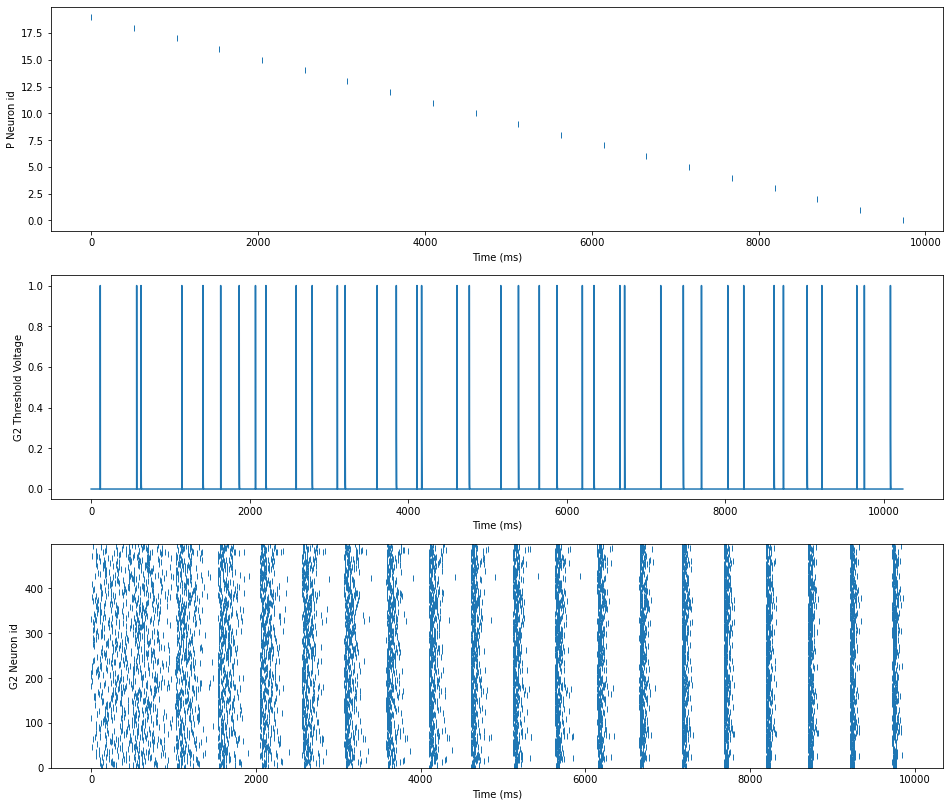

In [11]:
# The following plots output from the different monitors
fig, axs = plt.subplots(3,1,figsize=(16,14), gridspec_kw={'height_ratios': [2, 2, 2]})

subplot(3, 1, 1)
plot(SMP.t / ms, SMP.i, '|')
xlabel('Time (ms)')
ylabel('P Neuron id')

subplot(3, 1, 2)
plot(M1[1].t / ms, M1[1].v.T)
xlabel('Time (ms)')
ylabel('G2 Threshold Voltage')

subplot(3, 1, 3)
plot(SM1.t / ms, SM1.i, '|')
xlabel('Time (ms)')
ylabel('G2 Neuron id')
plt.ylim(y_low, y_high)


In [12]:

data_matrix = bits_per_slot - P_matrix

net2 = Network()

# To pass the sparse vector from Net1 into Net2 we create a SpikeGeneratorGroup  that uses the P1_timing from Net1 to generate
# the sparse bound vector which is the input to NeuronGroup G6 (S6).
P1 = SpikeGeneratorGroup(slots_per_vector, np.arange(slots_per_vector), P1_timing * ms)

net2.add(P1)

equ2 = '''
dv/dt = -v / tau : 1 
tau : second
ts:second
'''
# The G2 NeuronGroup performs the recurrent unbinding of the bound sparse vector in this case Neuron_1 connects to Neuron_0 etc. (S22.connect)
# Again the recurrent delay depends on the number of bit positions.
G2 = NeuronGroup(slots_per_vector, equ2, threshold='v >= 0.5', reset='v=0.0', method='euler')
G2.v = 0.0
G2.tau = 1 * ms

net2.add(G2)

SP2 = Synapses(P1, G2, 'w : 1', on_pre='v = 1.0')
SP2.connect(j='i')

net2.add(SP2)

# Recursively unbind with a delay of 'input_delay' between unbound vectors

S22 = Synapses(G2, G2, 'w : 1', on_pre='v = 1.0')
for n in range(0, slots_per_vector):
    S22.connect(i=n, j=(n - 1) % slots_per_vector)

S22.delay = (1 * input_delay) * ms

net2.add(S22)

# The unbound vector is fed directly into NeuronGroup G3 which performs the 'Clean-Up' memory operation by comparing it in parallel 
# with all of the vectors in the memory.  This operation relies on the alignemnt of the unbound vector spikes delayed by the transpose 
# of the data_matrix (S8.delay). N.B. we have used the predicted min_match to set the threshold for the clean-up memory and just outout
# the index of the best matching vector. Also note that the output order is the reverse of the input order.

G3 = NeuronGroup(mem_size, equ2, threshold='v >= 10', reset='v=0.0', method='euler')

G3.v = 1.0
G3.tau = 1.0 * ms

net2.add(G3)

range_array1 = range(0, mem_size)
S23 = Synapses(G2, G3, on_pre='v += 1.0')

for n in range(0, slots_per_vector):
    S23.connect(i=n, j=range_array1)

data_matrix2 = np.transpose(data_matrix)
S23.delay = np.reshape(data_matrix2, mem_size * slots_per_vector) * ms

net2.add(S23)

# Create the required monitors

SMP1 = SpikeMonitor(P1)
net2.add(SMP1)

SM2 = SpikeMonitor(G2)

net2.add(SM2)

SM3 = SpikeMonitor(G3)

net2.add(SM3)

M3 = StateMonitor(G3, 'v', record=True)

net2.add(M3)

# Run Network2 for delta milliseconds

net2.run((delta + bits_per_slot) * ms)


The G6 neuron group is stimulated from the P spike generator group with and the G7 neuron group.
The P spike generator generates a role vector role using the time delay on the G6 dendrites obtained from the P_matrix (S5.delay) and the G6 neuron group produces the sparse bound vector.

The G6 neurons perform the subtraction operation on the selected vectors. In this case Equ3 is a linearly increasing function with a time constant of bits_per_slot*ms (I=1.0).  On receiving the first spike from either role or filler vector the value of I=0.0 which holds the neuron potential constant until the second spike is received when I again becomes 1.0 and the neuron potential continues to increase until the threshold value v>1.0 when it fires. To give the required modulus addition the value of I is maintained at 1.0 to ensure a second vector is generated. One of these two vector will have the correct modulus timings and so we compare both vectors in the final 
neuron group stage (G8) to get the best match. 

This final NeuronGroup,G8, stage is the clean up memory operation using the transpose of the data_matrix to set the synaptic delays on the G8 dendrites. We only produce one output spike per match by using the refractory operator to suppress any further spikes. This could be improved to choose the largest matching spike.

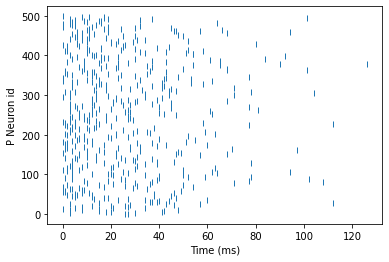

Text(0, 0.5, 'G3 Neuron id')

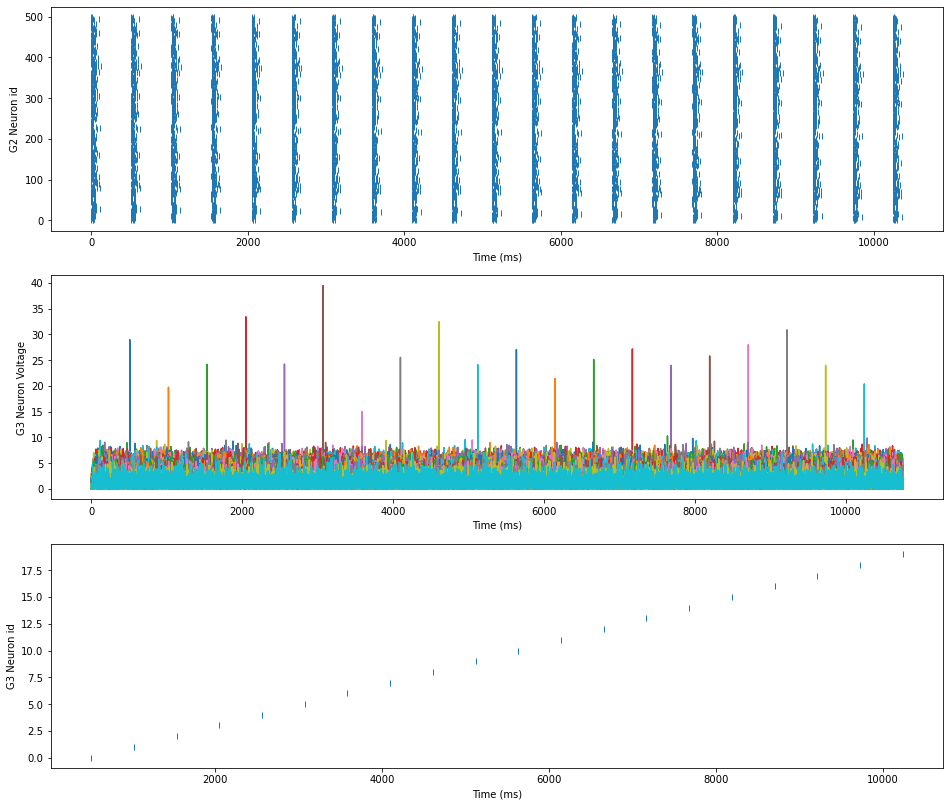

In [13]:
# Plot the sparse bound vector

plot(SMP1.t / ms, SMP1.i, '|')
xlabel('Time (ms)')
ylabel('P Neuron id')
show()

# Plot the sparse bound vector
fig, axs = plt.subplots(3,1,figsize=(16,14), gridspec_kw={'height_ratios': [2, 2, 2]})


subplot(3, 1, 1)
plot(SM2.t / ms, SM2.i, '|')
xlabel('Time (ms)')
ylabel('G2 Neuron id')
# plt.ylim(y_low,y_high)

subplot(3, 1, 2)
plot(M3.t / ms, M3.v.T)
xlabel('Time (ms)')
ylabel('G3 Neuron Voltage')

subplot(3, 1, 3)
plot(SM3.t / ms, SM3.i, '|')
xlabel('Time (ms)')
ylabel('G3 Neuron id')